In [5]:
pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [7]:
spark=SparkSession.builder.appName('ML-Bank').getOrCreate()
spark

In [8]:
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [9]:
# we can take a look at the five first columns in pandas
pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Input Variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome
Target Variable: deposit

In [10]:
df.groupby('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


Statistics summary for numeric variables

In [11]:
numeric_features=[t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,15.658036194230425,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,8.420739541006462,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,1,2,1,-1,0
4,max,95,81204,31,3881,63,854,58


##Data Preparation for Machine Learning

In [12]:
# Checking columns Datatypes
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [13]:
#Let's find out how many categorical and mumerical columns this dataset has
pd.DataFrame(df.take(10), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


It seems like there are multiple categorical columns, like job, marital, educations, default, loan, housing, contact, poutcome, and the rest is numerical, like balance, compaign, pdays, previous, age, and duration.

The data preparation process includes Category Indexing, One-Hot Encoding and VectorAssembler. VectorAssembler is a feature transformer that merges several columns into one vector column. The following codes are taken from databricks' official website, https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example, where it indexes each categorical column using StringIndexer, then converting them into one-hot ecnoded variables. Its output has the birnary vectors appended at the end of each row. So, stringIndexer is used once again to encode the labels to label indices. Finally, VectorAssembler is used to combine all the feature columns into a single vector column.

In [14]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Pipeline


In [15]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']+cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [16]:
pd.DataFrame(df.take(5), columns=df.columns)

,label,features,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Spliting data into train and test sets randomly. 


In [17]:
train, test=df.randomSplit([0.8, 0.2], seed=2018)
print('Training dataset count: ' + str(train.count()))
print('Test dataset count: ' + str(test.count()))

lr=LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lrModel=lr.fit(train)

Training dataset count: 8972
Test dataset count: 2190


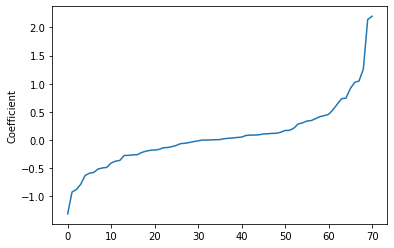

In [18]:
coefficients=np.sort(lrModel.coefficients)
plt.plot(coefficients)
plt.ylabel('Coefficient')
plt.show()

A regression coefficient describes the size and direction of the relationship between a predictor and the response variable. Coefficients are the numbers by which the values of the term are multiplied in a regression equation.

## Precision and Recall

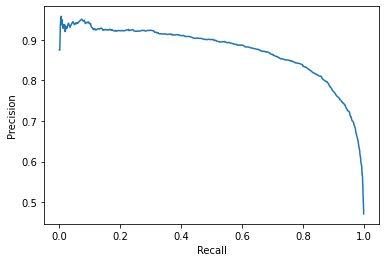

In [19]:
training_summary=lrModel.summary
precision_recall=training_summary.pr.toPandas()
plt.plot(precision_recall['recall'], precision_recall['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

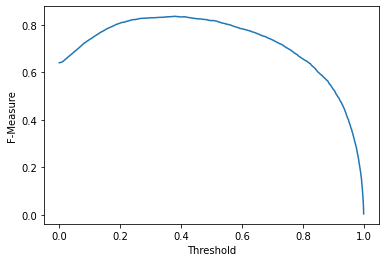

In [20]:
# setting the model threshold to maximize F-Measure
f=training_summary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'], f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [21]:
#Making predictions on the test set
predictions=lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawprediction', 'prediction', 'probability').show(5)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawprediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 60|management|  0.0|[0.72730006959987...|       0.0|[0.67421251204008...|
| 35|management|  0.0|[2.29136322150533...|       0.0|[0.90815921428002...|
| 33|management|  0.0|[2.01976617012765...|       0.0|[0.88285682845193...|
| 51|management|  0.0|[3.11789746375319...|       0.0|[0.95762499061061...|
| 54|management|  0.0|[2.28900284230393...|       0.0|[0.90796215460277...|
+---+----------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [23]:
# Evaluating our logistic regression model
evaluator=BinaryClassificationEvaluator()
print('Test Area UNDER ROC: ', evaluator.evaluate(predictions))

Test Area UNDER ROC:  0.8990096836313126


## Decision Tree Classifier

In [25]:
dt=DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3)
dtModel=dt.fit(train)
predictions=dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 60|management|  0.0|[905.0,1422.0]|       1.0|[0.38891276321443...|
| 35|management|  0.0|[905.0,1422.0]|       1.0|[0.38891276321443...|
| 33|management|  0.0|[2876.0,471.0]|       0.0|[0.85927696444577...|
| 51|management|  0.0|[2876.0,471.0]|       0.0|[0.85927696444577...|
| 54|management|  0.0|[2876.0,471.0]|       0.0|[0.85927696444577...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 5 rows



In [26]:
# Evaluating our Decision Tree Model
evaluator=BinaryClassificationEvaluator()
print('Test Area Under ROC: ' + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7575615546230764


It seems like the Decision tree model hasn't performed well here. It can be improved by ensemble methods, like Random Forest and Gradident-Boosted tree.

## Random Forest Classifier

In [29]:
rfc=RandomForestClassifier(featuresCol='features', labelCol='label')
rfcModel=rfc.fit(train)
predictions=rfcModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 60|management|  0.0|[8.88446096568570...|       1.0|[0.44422304828428...|
| 35|management|  0.0|[13.5128044833599...|       0.0|[0.67564022416799...|
| 33|management|  0.0|[14.2819243819217...|       0.0|[0.71409621909608...|
| 51|management|  0.0|[13.9324718141070...|       0.0|[0.69662359070535...|
| 54|management|  0.0|[13.1208730020196...|       0.0|[0.65604365010097...|
+---+----------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [31]:
#Evaluating Random Forest Classifier
evaluator=BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8765443434521343


## Gradient-Boosted Tree Classifier

In [32]:
gbtc=GBTClassifier(maxIter=10)
gbtcModel=gbtc.fit(train)
predictions=gbtcModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 60|management|  0.0|[-0.4540989519839...|       1.0|[0.28736874333946...|
| 35|management|  0.0|[-9.1159901474407...|       1.0|[0.49954420061888...|
| 33|management|  0.0|[1.21698054227270...|       0.0|[0.91938061611760...|
| 51|management|  0.0|[1.23314709980651...|       0.0|[0.92174487825120...|
| 54|management|  0.0|[1.18269457166198...|       0.0|[0.91414969070229...|
+---+----------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [34]:
#Evaluating GBTC
evaluator=BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8934024262083287


Gradient-Boosted Tree classifier has preformed quite well and we still can improve it tuning the model with ParamGridBuilder and CrossValidator. But first we need to find out all params and their definitions to see if they are available for tuning by using explainParam() function. 

In [35]:
print(gbtc.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [37]:
paramGrid=(ParamGridBuilder().addGrid(gbtc.maxDepth, [2, 4, 6])
                             .addGrid(gbtc.maxBins, [20, 60])
                             .addGrid(gbtc.maxIter, [10, 20]).build())

cv=CrossValidator(estimator=gbtc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel=cv.fit(train)
predictions=cvModel.transform(test)
evaluator.evaluate(predictions)

0.9018068432330197